Some initial imports, do **NOT** write any new code here:

In [ ]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from huggingface_hub import hf_hub_download

In [ ]:
from plotly.subplots import make_subplots
from plotly import graph_objs as go
from sklearn.metrics import precision_score, recall_score, accuracy_score
from torchvision.transforms import Normalize

from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display, clear_output
from collections import Counter
from tqdm import tqdm

# Question 2: ECG Beat Classification and Anomaly Detection

Electrocardiography (ECG) records the electrical activity of the heart over time using electrodes placed on the skin. ECG signals are widely used in clinical practice for detecting arrhythmias, monitoring cardiac function, and guiding diagnosis and treatment. Automated analysis of ECG signals is therefore an important application area for deep learning, with direct implications for screening, triage, and decision support.

In this question, you will work with a cleaned ECG dataset. The dataset contains **197 records** drawn from **three arrhythmia databases**. All signals have been resampled to **128 Hz**, and each recording is approximately **30 minutes** in duration. Each record is stored as a Python dictionary with the following fields:

- `patient_id`: an anonymised identifier for the patient from whom the recording was obtained.  
- `source_db`: the originating database for this record.  
- `sampling_rate`: the sampling frequency of the signal in Hz (128 for this cleaned dataset).  
- `signal`: a one-dimensional array containing the ECG time series.  
- `beat_locs`: an array of sample indices marking the onset of each annotated heartbeat in the signal.  
- `beat_labels`: an array of integer labels associated with each beat location.

Beat labels in this assessment have been mapped to a simplified index space from **0** to **4**, where **0** denotes normal beats, **1** and **2** correspond to different abnormality subclasses (supra ventricular ectopic (SVEB) and ventricular ectopic beats (VEB)), and **3** represents unknown or other beats. The exact mapping between indices and the original clinical annotation classes is provided in the accompanying file `class_mapping.json`. You should refer to this file when interpreting the label distribution and when designing your models.

This question is divided into three parts:

- **Part 2.A – Exploratory Data Analysis and Tooling**: you will perform basic exploration of the ECG signals and annotations, and construct simple plotting and preprocessing utilities to support the later tasks.  
- **Part 2.B – Classification and Anomaly Detection**: you will build a supervised deep learning model for beat-level classification, using the simplified label scheme, and explicitly examine its behaviour for normal versus abnormal beats.  
- **Part 2.C – Discussion**: you will critically discuss your modelling choices, results, limitations, and potential improvements, in a concise written analysis guided by the prompts.

You should approach these parts progressively: insights and tools developed in Part 2.A are expected to inform and support your solutions in Parts 2.B and 2.C.

<br>

---

<br>

The next few blocks of code provided in the notebook will download the dataset, load the ECG records into memory, and import the accompanying class–mapping file required for interpreting the beat labels.

In [ ]:
# Use this snippet to download the dataset
dataset = load_dataset("dpelacani/ecg-led2-cleaned")

# download class_mapping.json
mapping_path = hf_hub_download(
    repo_id="dpelacani/ecg-led2-cleaned",
    filename="class_mapping.json",
    repo_type="dataset"
)

# load it
with open(mapping_path, "r") as f:
    idx_to_class = json.load(f)

print(dataset, idx_to_class)  # print dataset and mapping

<br><br>

## 2.A) Exploratory Data Analysis and Pre-processing

The goal of this part is to carry out a set of simple exploratory checks on the ECG dataset and to prepare the beat-level representation that will be used in later tasks. Two helper functions are provided:

- **`plot_signal`**: plots a segment of the ECG signal together with its annotated beat locations and labels.  
- **`split_by_beat`**: takes a full ECG recording and returns a list of individual beat segments based on the annotated beat locations.

Using these tools, you must complete the following:

1. **Visualise the data**  
   Use `plot_signal` to visualise a **subset of 50 consecutive beats** for **five different patients**, ensuring that beat locations and labels are annotated in the plot. These examples should give you an intuitive sense of how the signals vary across patients and beat types.

2. **Construct the beat-level dataset**  
   Use `split_by_beat` to compile a dataset where **each beat is one sample**. Build two aligned arrays/lists:
   - one containing the beat waveforms: `list[(floats)]`
   - one containing the corresponding beat labels (0–4) `list[(int)]`

3. **Apply a simple pre-processing filter**  
   Exclude beats whose durations fall outside physiologically plausible ranges. Specifically, keep only beats whose lengths fall between:  
   - **minimum length** corresponding to a **maximum heart rate of 240 bpm** (32 samples)  
   - **maximum length** corresponding to a **minimum heart rate of 30 bpm** (256 samples)  
   
   Beats outside this range should be removed, as they likely reflect annotation errors or segmentation issues.

4. **Plot summary statistics**  
   After filtering, produce two histograms:
   - one showing the **distribution of beat lengths**,  
   - one showing the **distribution of beat classes** (0–4).  

These steps should give you a clear initial understanding of the dataset and will provide the structured inputs required for the classification task in Part 2.B.

<br>

Here are the helper functions:

In [ ]:
def plot_signal(
        signal,
        title="ECG Signal",
        sampling_rate=128,
        beat_locations=None,
        beat_annotations=None,
        ax = None,

    ):
    """
    Plots an ECG signal with optional anomalous beat annotations.
    Parameters:
        signal (np.ndarray): The ECG signal to plot.
        title (str): The title of the plot.
        sampling_rate (int): The sampling rate of the signal in Hz.
        beat_locations (list or np.ndarray): Indices of beat locations in the signal.
        beat_annotations (list): Annotations corresponding to the beat locations.
        ax (matplotlib.axes.Axes): Optional matplotlib axes to plot on.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 5))

    time = np.arange(len(signal)) / sampling_rate / 60.
    ax.plot(time, signal)

    if beat_locations is not None:
        ax.scatter(beat_locations / sampling_rate / 60., signal[beat_locations], color='red', label='BEAT', marker='o')
        if beat_annotations is not None:
            for loc, ann in zip(beat_locations, beat_annotations):
                if ann != 'NOR':
                    ax.text(loc / sampling_rate / 60. + 0.05*np.max(time), signal[loc] + 0.05, ann, color='red', fontsize=8, weight='bold')

    ax.set_title(title)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Normalised Amplitude")
    ax.set_ylim([-0.5, 1])
    ax.grid()

    if ax is None:
        plt.show()

In [ ]:
def split_by_beat(signal, beat_locs):
    """
    Splits the ECG signal into individual beats based on beat locations.
    Parameters:
        signal (np.ndarray): The ECG signal to split.
        beat_locs (list or np.ndarray): Indices of beat locations in the signal.
    Returns:
        list: A list of individual beats extracted from the signal."""
    beats = []
    starts = [0] + beat_locs.tolist()[:-1]
    ends = beat_locs.tolist() + [len(signal)]
    for start, end in zip(starts, ends):
        beats.append(signal[start:end])
    return beats

<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise the data**

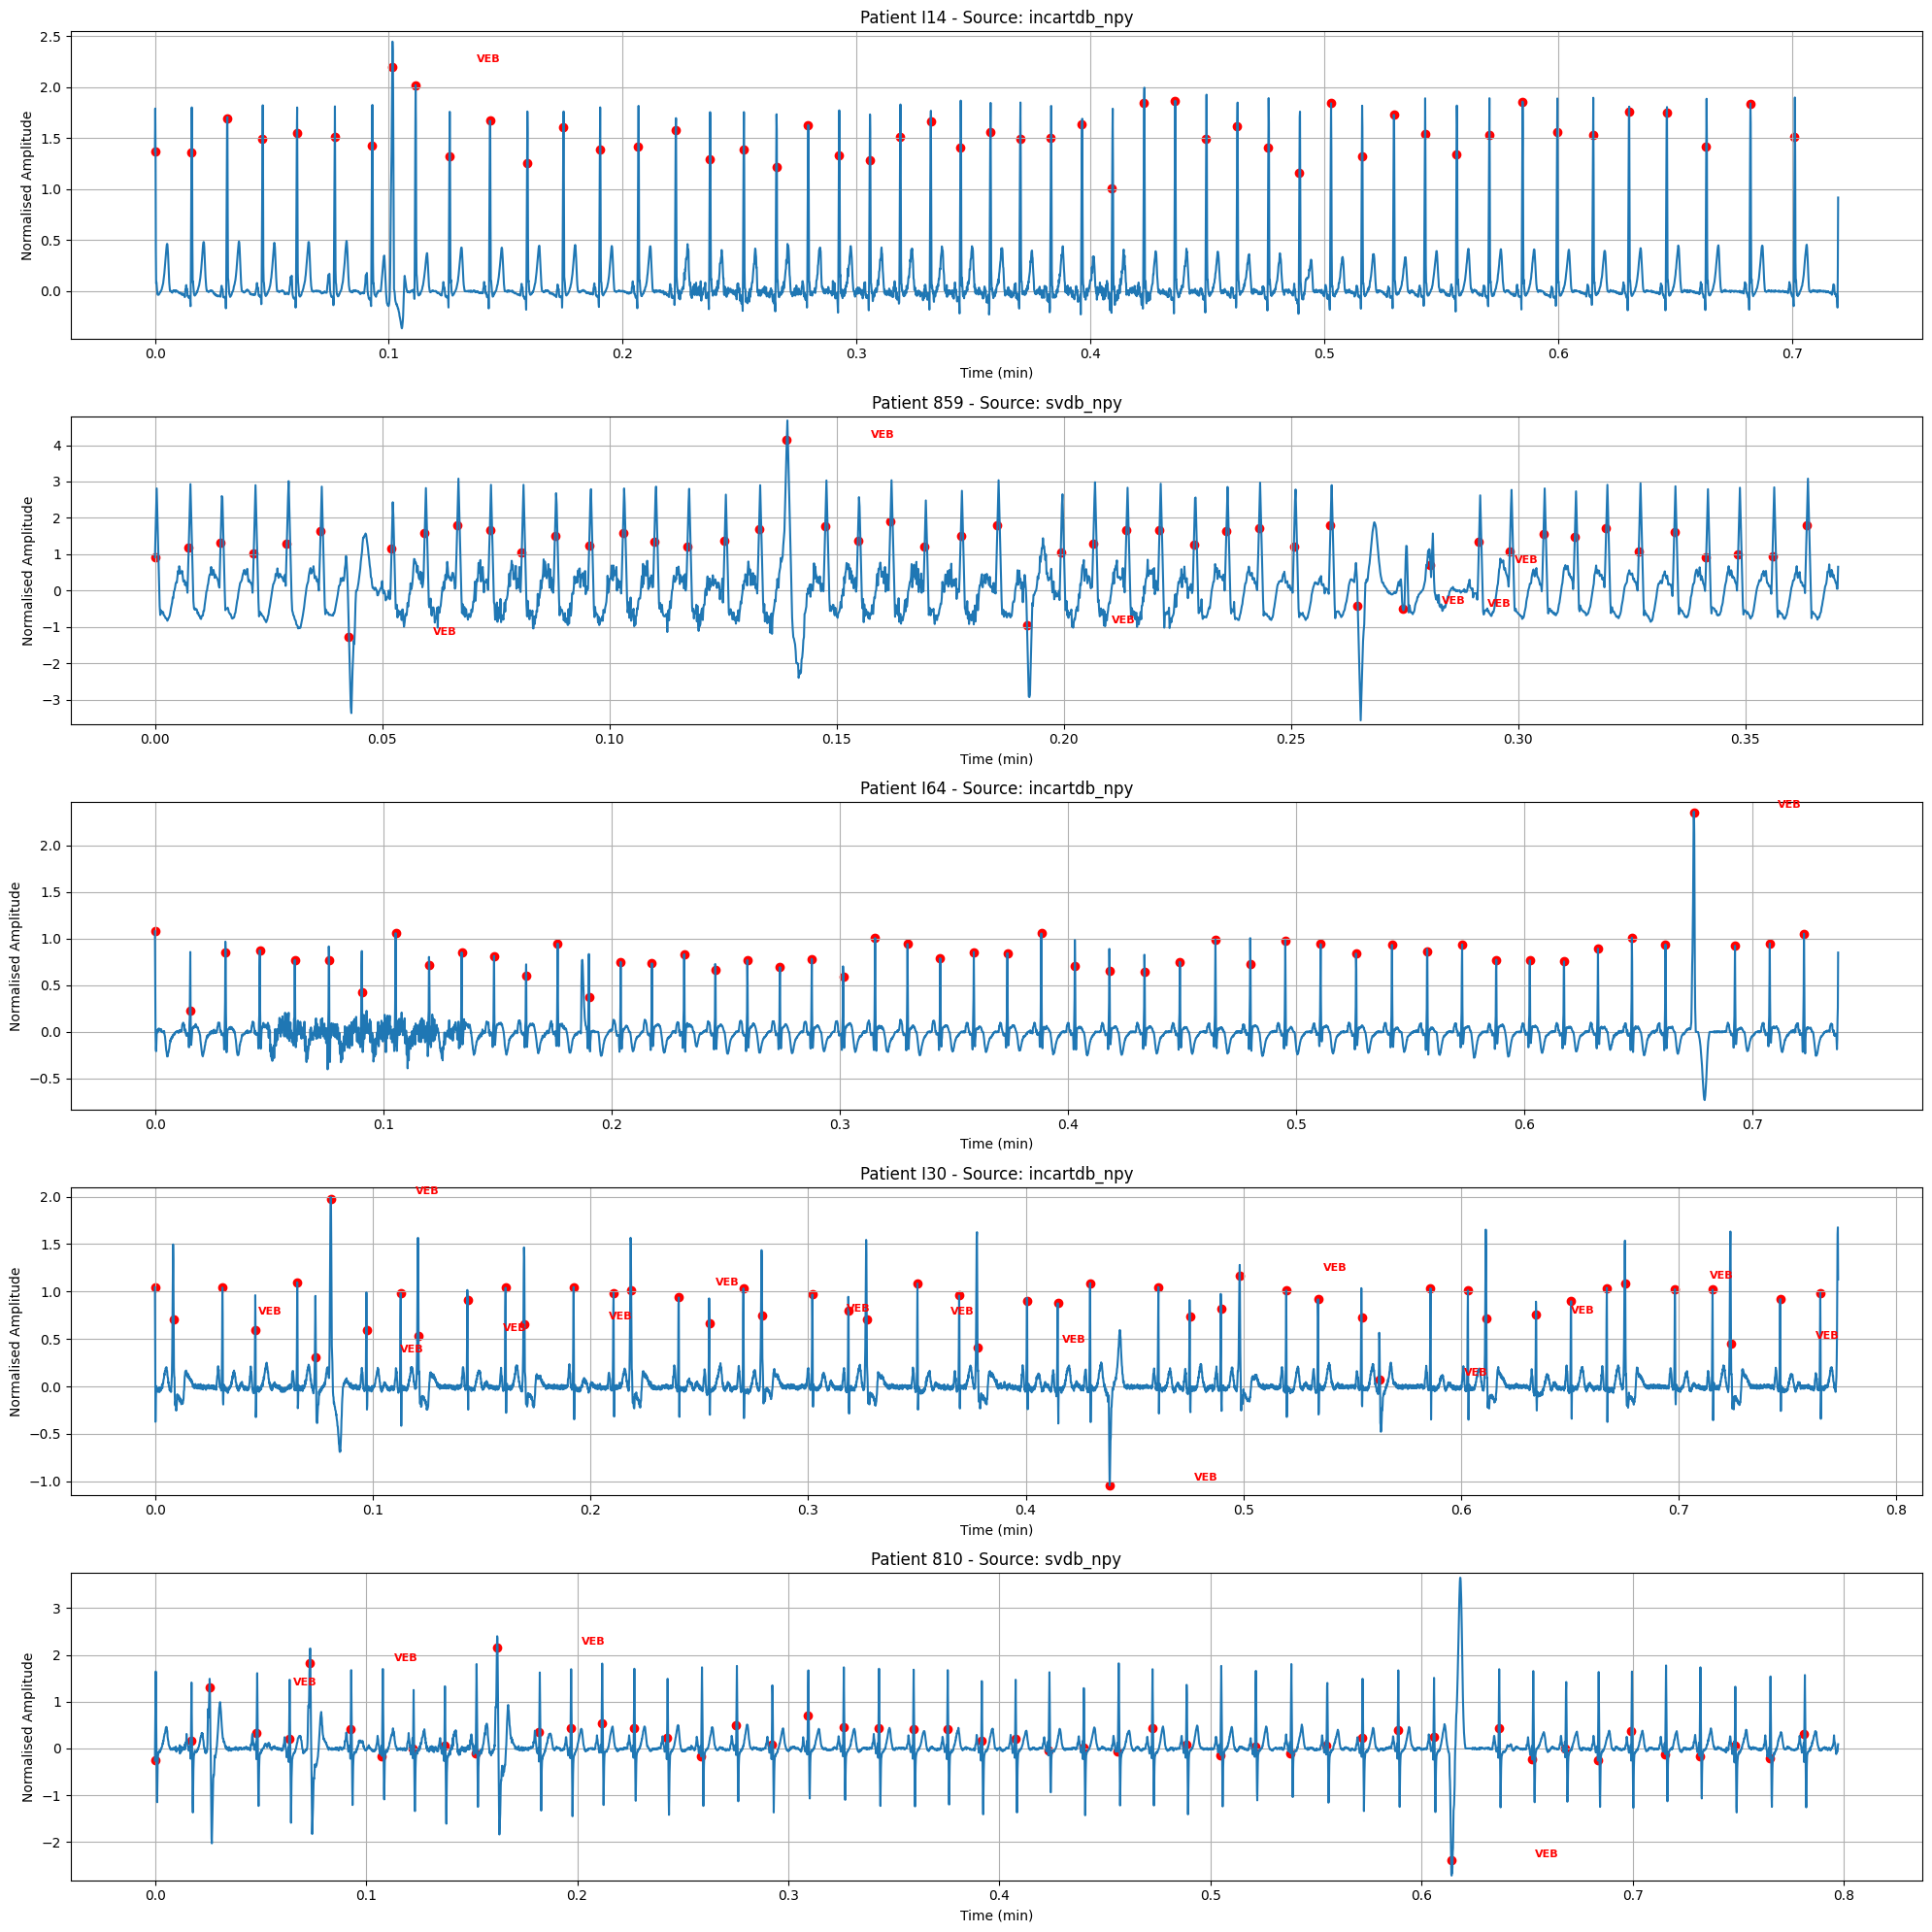

In [13]:
label_to_annotation = {int(k): v for k, v in idx_to_class.items()}
patient_indices = [0, 40, 80, 120, 160]

fig, axes = plt.subplots(5, 1, figsize=(20, 20))

for i, patient_idx in enumerate(patient_indices):
    record = dataset['train'][patient_idx]
    signal = np.array(record['signal'])
    beat_locs = np.array(record['beat_locs'])
    beat_labels = np.array(record['beat_labels'])

    # Select 50 consecutive beats starting from beat 50
    start_beat_idx = 50
    end_beat_idx = min(start_beat_idx + 50, len(beat_locs) - 1)

    # Extract signal segment and adjust beat locations
    start_sample = beat_locs[start_beat_idx]
    end_sample = beat_locs[end_beat_idx]
    signal_segment = signal[start_sample:end_sample]
    beat_locs_segment = beat_locs[start_beat_idx:end_beat_idx] - start_sample
    beat_labels_segment = beat_labels[start_beat_idx:end_beat_idx]

    annotations = [label_to_annotation[int(l)] for l in beat_labels_segment]

    plot_signal(
        signal=signal_segment,
        title=f"Patient {record['patient_id']} - Source: {record['source_db']}",
        sampling_rate=record['sampling_rate'],
        beat_locations=beat_locs_segment,
        beat_annotations=annotations,
        ax=axes[i]
    )

    # Auto-scale y-axis to fit data
    y_min, y_max = signal_segment.min(), signal_segment.max()
    axes[i].set_ylim([y_min - 0.1, y_max + 0.1])

plt.tight_layout()
plt.show()

<br>

2. **Construct the beat-level dataset**

In [14]:
all_beats = []   # List of beat waveforms
all_labels = []  # List of corresponding labels (0-4)

# Iterate through all records in the dataset
for i in range(len(dataset['train'])):
    record = dataset['train'][i]
    signal = np.array(record['signal'])
    beat_locs = np.array(record['beat_locs'])
    beat_labels = record['beat_labels']

    # Split signal into individual beats
    beats = split_by_beat(signal, beat_locs)

    # Add beats and labels to our lists
    # Note: split_by_beat returns len(beat_locs) beats, matching len(beat_labels)
    for beat, label in zip(beats, beat_labels):
        all_beats.append(beat)
        all_labels.append(int(label))

print(f"Total beats: {len(all_beats)}")
print(f"Total labels: {len(all_labels)}")
print(f"Label distribution: {[(l, all_labels.count(l)) for l in sorted(set(all_labels))]}")

# Beats and labels have same amount

Total beats: 461216
Total labels: 461216
Label distribution: [(0, 405800), (1, 17308), (2, 38008), (3, 100)]


<br>

3. **Apply a simple pre-processing filter**  

In [17]:
# Drop class 3 entirely as suggested in briefing
all_beats = [b for b, l in zip(all_beats, all_labels) if l != 3]
all_labels = [l for l in all_labels if l != 3]

print(f"Total beats: {len(all_beats)}")
print(f"Total labels: {len(all_labels)}")
print(f"Label distribution: {[(l, all_labels.count(l)) for l in sorted(set(all_labels))]}")

# Remove non possible
min_len = 32
max_len = 256

filtered_beats = []
filtered_labels = []

for beat, label in zip(all_beats, all_labels):
    if min_len <= len(beat) <= max_len:
        filtered_beats.append(beat)
        filtered_labels.append(label)

print(f"Total beats: {len(filtered_beats)}")
print(f"Total labels: {len(filtered_labels)}")
print(f"Label distribution: {[(l, filtered_labels.count(l)) for l in sorted(set(filtered_labels))]}")

Total beats: 461116
Total labels: 461116
Label distribution: [(0, 405800), (1, 17308), (2, 38008)]
Total beats: 460789
Total labels: 460789
Label distribution: [(0, 405489), (1, 17300), (2, 38000)]


<br>

4. **Plot summary statistics**

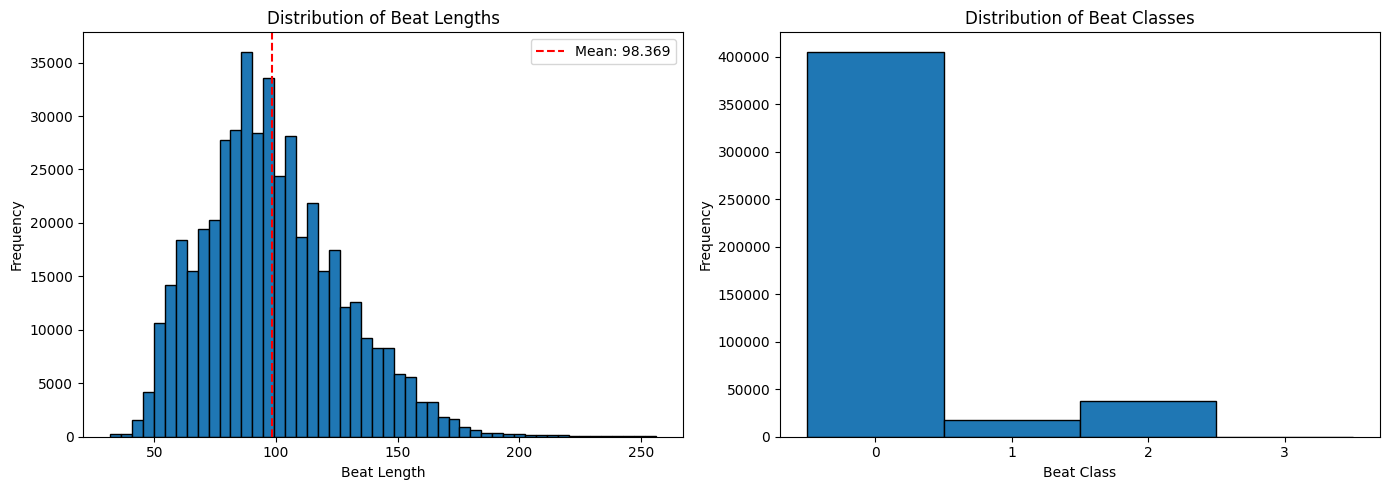

Class counts:
  Class 0: 405489 (88.00%)
  Class 1: 17300 (3.75%)
  Class 2: 38000 (8.25%)


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of beat lengths
beat_lengths = [len(beat) for beat in filtered_beats]
axes[0].hist(beat_lengths, bins=50, edgecolor='black')
axes[0].axvline(np.asarray(beat_lengths).mean(), color='red', linestyle='--', label=f'Mean: {np.asarray(beat_lengths).mean():.3f}')
axes[0].set_xlabel('Beat Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Beat Lengths')
axes[0].legend()

# Histogram of beat classes
axes[1].hist(filtered_labels, bins=[-0.5, 0.5, 1.5, 2.5, 3.5], edgecolor='black')
axes[1].set_xlabel('Beat Class')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Beat Classes')
axes[1].set_xticks([0, 1, 2, 3])

plt.tight_layout()
plt.show()

# Print class counts
print("Class counts:")
for label in sorted(set(filtered_labels)):
    count = filtered_labels.count(label)
    print(f"  Class {label}: {count} ({100*count/len(filtered_labels):.2f}%)")

<br><br>

## 2.B) Classification and Anomaly Detection

In this part you will build a supervised **beat-level classifier** using the segmented beats prepared in Part 2.A. Each beat is treated as an individual sample with a label in the simplified index space (0–4). Key points to consider:

- You should drop all beats with a label of **3** and only train the classifier for labels **0**, **1** and **2**. This will make the training easier, given the significant class imbalance.

- Beats naturally vary in duration, so you must decide how to convert them into a consistent representation suitable for a model. You are free to choose any reasonable approach; at the simplest level, you may choose to zero-pad beats to a fixed length, but more refined strategies are also acceptable.

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, the train/validation splits, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem.

- As established in Part 2.A, the dataset is **heavily imbalanced**, with normal beats dominating the distribution. This affects both training and evaluation: models that ignore imbalance tend to overfit normal beats while failing on minority abnormal classes. **Strong solutions will address imbalance explicitly and will aim to produce models that perform reliably across all classes, not only the majority one.** You are, therefore, required to report each validation metric twice: one for normal (0) and one for abnormal (1-2), separately.

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

<br><br>

## 2.C) Discussion (max 250 words)

Reflect critically on your solution to Part 2.B. In your discussion, address the following points:

1. **Modelling choices**

   Explain the main decisions behind your model design(s) and why you believe these choices are suitable for this task.

2. **Performance and validation**
   
   Interpret your model’s performance on normal versus abnormal beats using the evaluation metrics you selected. Comment on how class imbalance affected the results and what strategies you have sought to mitigate its impact.

3. **Limitations and improvements**
   
   Identify the main limitations of your approach and outline specific steps that could meaningfully improve performance. You may refer to architectural changes, alternative representations, different imbalance-handling strategies, or improved validation schemes.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

// Text answer



<br>

---

<br>